In [1]:
from IPython.display import display, HTML
from sympy.abc import alpha

display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
# Brightway imports
import bw2analyzer as ba
import bw2calc as bc
import bw2data as bd
import bw2io as bi
import brightway2 as bw

In [3]:
import pandas as pd
import numpy as np
import datetime
import os

In [4]:
# Custom functions
from useful_lca_functions import get_inventory_dataset, init_simple_lca, multi_lcia, multi_contribution_analysis, direct_technosphere_contribution_multi_activities_fixed,  calculate_projected_impacts
from visualisation_functions import plot_multilca_impacts, plot_contribution_analysis, plot_production_impacts, plot_incremental_impacts, plot_iwplus_contributions, plot_scenario_production_comparison, pie_charts_technosphere_contribution

# Set projects, LCI and LCIA methods

In [6]:
BW_PROJECT = 'regioinvent_2025' # insert your project name here
bd.projects.set_current(BW_PROJECT)
bd.databases

Databases dictionary with 9 object(s):
	LIB raw materials
	Regioinvent
	biosphere3
	biosphere3_spatialized_flows
	cobalt
	ecoinvent-3.10-cutoff
	ecoinvent-3.10-cutoff regionalized
	graphite
	lithium

In [7]:
EI_DB = 'ecoinvent-3.10-cutoff'
RI_DB = 'Regioinvent'
LIB_RM_DB = 'LIB raw materials'

## Import LCI

In [9]:
# (mineral name: activity name, reference product, location)
INVENTORIES = {
    ## From EI
    "Neodymium":        ("rare earth oxides production, from rare earth carbonate concentrate", "neodymium oxide", "RoW"),
    "Copper concentrate, Canada": ('copper mine operation and beneficiation, sulfide ore', 'copper concentrate, sulfide ore', 'CA'),
    "Market for copper, cathode": ('market for copper, cathode', 'copper, cathode', 'GLO'),
    
    # From Istrate et al (2024)
    "Lithium hydroxide, brine":        ("lithium hydroxide production, Salar de Atacama", "lithium hydroxide, battery grade", "CL"),
    "Lithium hydroxide, spodumene":    ("lithium hydroxide production, from Australian spodumene", "lithium hydroxide, battery grade", "CN"),
    "Cobalt":                ("cobalt sulfate production, from copper-cobalt ore, economic allocation", "cobalt sulfate", "CN"),
    "Nickel":                ("nickel sulfate production, average excluding China, economic allocation", "nickel sulfate", "GLO"),
    "Graphite, natural":     ("natural graphite production, battery grade, from Heilongjiang", "natural graphite, battery grade", "CN"),
    "Graphite, synthetic":   ("graphite powder coating", "synthetic graphite, battery grade", "CN"),
    
    "Lithium carbonate, brine":        ("lithium carbonate production, Salar de Atacama", "lithium carbonate, battery grade", "CL"),
    "Lithium carbonate, spodumene":    ("lithium carbonate production, from Australian spodumene", "lithium carbonate, battery grade", "CN"),
}

In [14]:
INVENTORIES_EI = {
    "Neodymium": ("market for neodymium oxide", "neodymium oxide", "GLO"), # CAN not here
    "Copper": ("market for copper, cathode", "copper, cathode", 'GLO'),    
    "Lithium carbonate": ("market for lithium carbonate", "lithium carbonate", "GLO"),
    "Cobalt oxide": ("market for cobalt oxide", "cobalt oxide", "GLO"),
    "Nickel": ("market for nickel, class 1", "nickel, class 1", "GLO"),
    "Graphite": ("market for graphite", "graphite", "GLO")
}

In [15]:
# If we take consumption market activities 
# (mineral name: activity name, reference product, location)
INVENTORIES_RI = {
    "Neodymium": ("consumption market for neodymium oxide", "neodymium oxide", "US"), # CAN not here
    "Copper": ("consumption market for copper, cathode", "copper, cathode", 'CA'),    
    "Lithium carbonate": ("consumption market for lithium carbonate", "lithium carbonate", "CA"),
    "Cobalt oxide": ("consumption market for cobalt oxide", "cobalt oxide", "CA"),
    "Nickel": ("consumption market for nickel, class 1", "nickel, class 1", "CA"),
    "Graphite": ("consumption market for graphite", "graphite", "US"), # US     
}

In [16]:
INVENTORIES_EI_ds = get_inventory_dataset(INVENTORIES_EI, database_names=[EI_DB, LIB_RM_DB])

In [17]:
INVENTORIES_RI_ds = get_inventory_dataset(INVENTORIES_RI, database_names=[RI_DB])

## Pick LCIA methods

In [18]:
# We can also import some from IW+2.1
expert_ei310 = 'data/IW+2.1/impact_world_plus_21_brightway2_expert_version_ei310.5535d12bedce3770ffef004e84229fd1.bw2package'
bw.BW2Package.import_file(expert_ei310)

[Brightway2 Method: IMPACT World+ Damage 2.1 for ecoinvent v3.10: Ecosystem quality: Climate change, ecosystem quality, long term,
 Brightway2 Method: IMPACT World+ Damage 2.1 for ecoinvent v3.10: Ecosystem quality: Climate change, ecosystem quality, short term,
 Brightway2 Method: IMPACT World+ Damage 2.1 for ecoinvent v3.10: Human health: Climate change, human health, long term,
 Brightway2 Method: IMPACT World+ Damage 2.1 for ecoinvent v3.10: Human health: Climate change, human health, short term,
 Brightway2 Method: IMPACT World+ Midpoint 2.1 for ecoinvent v3.10: Midpoint: Climate change, long term,
 Brightway2 Method: IMPACT World+ Midpoint 2.1 for ecoinvent v3.10: Midpoint: Climate change, short term,
 Brightway2 Method: IMPACT World+ Damage 2.1 for ecoinvent v3.10: Ecosystem quality: Fisheries impact,
 Brightway2 Method: IMPACT World+ Midpoint 2.1 for ecoinvent v3.10: Midpoint: Fossil and nuclear energy use,
 Brightway2 Method: IMPACT World+ Midpoint 2.1 for ecoinvent v3.10: Mid

In [19]:
# Filter and display methods that contain "IMPACT World+" in their names
iw_methods = [method for method in bd.methods if "impact world+" in " ".join(method).lower()]
df_iw_methods = pd.DataFrame(iw_methods, columns=["Method", "Impact Category", "Subcategory"])
df_iw_methods.to_csv(r'data/IW+2.1/iw_methods_3.10.csv', index=False)

In [20]:
# To take them all
IMPACT_METHODS_ALL = {method[-1]: method for method in iw_methods}
IMPACT_METHODS_ALL

{'carbon footprint': ('IMPACT World+ v2.0.1, footprint version',
  'climate change',
  'carbon footprint'),
 'remaining ecosystem quality damage': ('IMPACT World+ v2.0.1, footprint version',
  'ecosystem quality',
  'remaining ecosystem quality damage'),
 'fossil and nuclear energy use': ('IMPACT World+ v2.0.1, footprint version',
  'energy resources: non-renewable',
  'fossil and nuclear energy use'),
 'remaining human health damage': ('IMPACT World+ v2.0.1, footprint version',
  'human health',
  'remaining human health damage'),
 'water scarcity footprint': ('IMPACT World+ v2.0.1, footprint version',
  'water use',
  'water scarcity footprint'),
 'Climate change, ecosystem quality, long term': ('IMPACT World+ Damage 2.1 for ecoinvent v3.10',
  'Ecosystem quality',
  'Climate change, ecosystem quality, long term'),
 'Climate change, ecosystem quality, short term': ('IMPACT World+ Damage 2.1 for ecoinvent v3.10',
  'Ecosystem quality',
  'Climate change, ecosystem quality, short term'

In [21]:
IMPACT_METHODS = {
#'Climate change ST': ('IMPACT World+ Midpoint 2.0.1_regionalized','Midpoint', 'Climate change, short term'), 
'Total HH': ('IMPACT World+ Damage 2.1 for ecoinvent v3.10','Human health', 'Total human health'), 
'Total EQ': ('IMPACT World+ Damage 2.1 for ecoinvent v3.10','Ecosystem quality', 'Total ecosystem quality'), 
}


# Calculate specific impacts (e.g. per mass)

## With inventories from EI and other LCI

In [22]:
# Initialize LCA object
lca_ei = init_simple_lca(INVENTORIES_EI_ds["Neodymium"])

In [23]:
specific_lca_ei = {}
for rm in INVENTORIES_EI_ds:
    impacts = multi_lcia(lca_ei, INVENTORIES_EI_ds[rm], IMPACT_METHODS)
    specific_lca_ei[rm] = impacts

specific_lca_ei = pd.DataFrame(specific_lca_ei).T
specific_lca_ei = specific_lca_ei.reset_index().rename(columns={
    'index': 'Commodity',
})

In [24]:
specific_lca_ei

,Commodity,Total HH (DALY),Total EQ (PDF.m2.yr)
0,Neodymium,4.736890e-04,111.340747
1,Copper,2.354260e-04,37.624968
2,Lithium carbonate,7.082792e-05,8.446946
3,Cobalt oxide,6.373749e-04,43.051577
4,Nickel,3.470230e-04,68.017610
5,Graphite,5.974026e-07,0.080919


## With Regioinvent

In [25]:
# Initialize LCA object
lca_ri = init_simple_lca(INVENTORIES_RI_ds["Neodymium"])

In [26]:
specific_lca_ri = {}
for rm in INVENTORIES_RI_ds:
    impacts = multi_lcia(lca_ri, INVENTORIES_RI_ds[rm], IMPACT_METHODS)
    specific_lca_ri[rm] = impacts

specific_lca_ri = pd.DataFrame(specific_lca_ri).T
specific_lca_ri = specific_lca_ri.reset_index().rename(columns={
    'index': 'Commodity',
})

In [27]:
specific_lca_ri

,Commodity,Total HH (DALY),Total EQ (PDF.m2.yr)
0,Neodymium,3.515821e-04,69.470936
1,Copper,1.820514e-04,27.227589
2,Lithium carbonate,4.362545e-05,5.292085
3,Cobalt oxide,2.554897e-04,31.457421
4,Nickel,1.109526e-04,37.349769
5,Graphite,4.431033e-07,0.059949


## Plotting

Plot saved to results/specific_lca_results/lca_impacts_ei.png


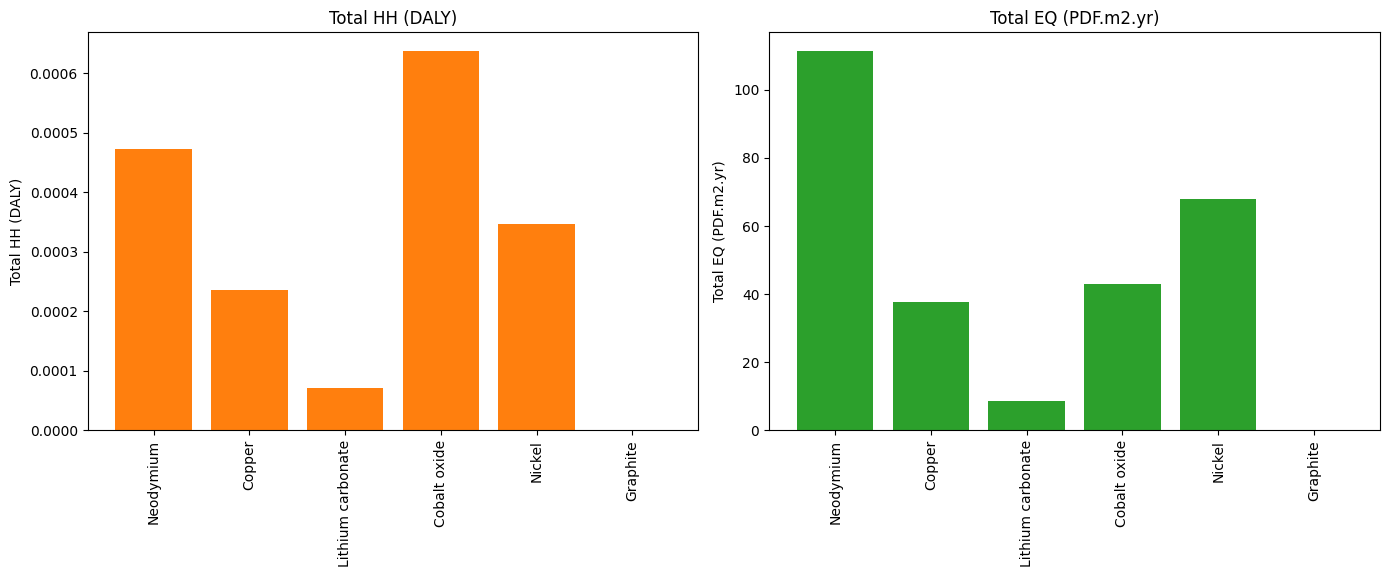

In [28]:
# Call the function
plot_multilca_impacts(specific_lca_ei, 
                 colors=["#ff7f0e", "#2ca02c"], 
                 save_path="results/specific_lca_results/lca_impacts_ei.png")

Plot saved to results/demand_lca_results/specific_lca_impacts_regioinvent.png


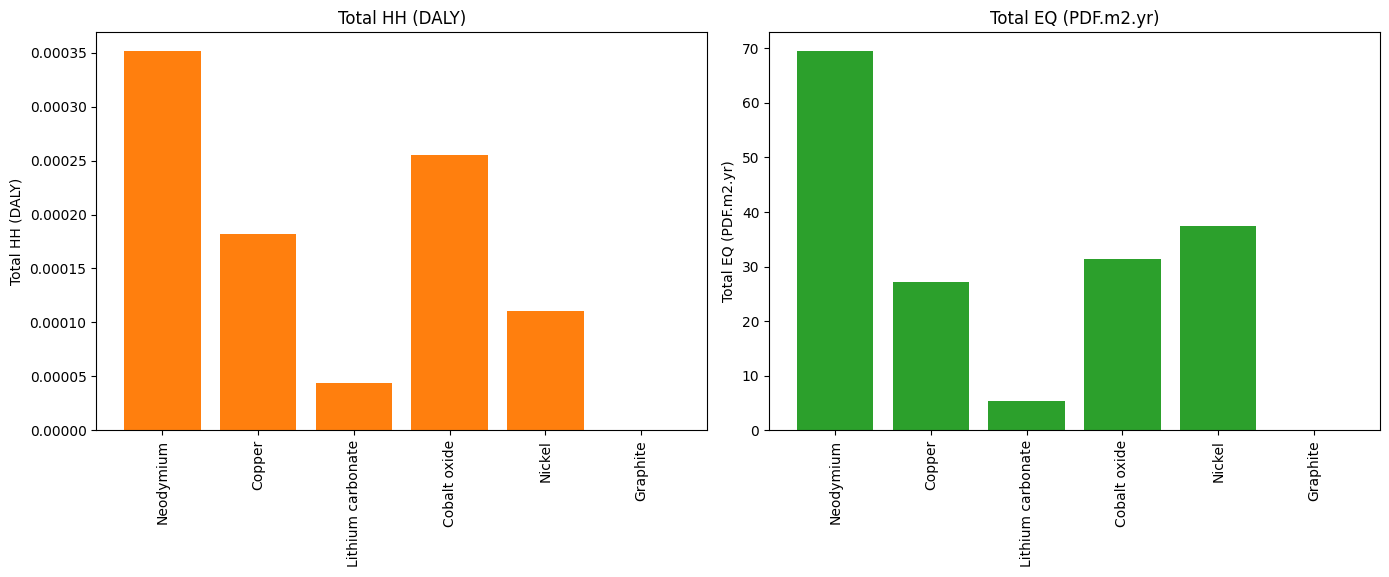

In [29]:
# Call the function
plot_multilca_impacts(specific_lca_ri, 
                 colors=["#ff7f0e", "#2ca02c"], 
                 save_path="results/demand_lca_results/specific_lca_impacts_regioinvent.png")

In [33]:
#specific_lca.to_csv(f"results/specific_lca_results/specific_results_{datetime.datetime.today().strftime('%d-%m-%Y')}.csv", index_label="Raw material")

## Contribution analysis

In [30]:
# Initialize a dictionary to store contribution results for each inventory
contribution_results = {}

# Loop through each inventory and perform contribution analysis
for rm_name, rm_ds in INVENTORIES_EI_ds.items():
    lca = init_simple_lca(rm_ds)
    contributions = multi_contribution_analysis(lca, IMPACT_METHODS, top_n=10, threshold=0.01)  # Set your threshold here
    contribution_results[rm_name] = contributions

# Convert the results into a more readable format for analysis
contribution_dfs = {}

for rm_name, impacts in contribution_results.items():
    for impact_name, contributions in impacts.items():
        df = pd.DataFrame(contributions)
        df["Inventory"] = rm_name
        df["Impact Category"] = impact_name
        contribution_dfs[(rm_name, impact_name)] = df

# Combine all individual DataFrames into one for easy viewing
contribution_analysis_df = pd.concat(contribution_dfs.values(), ignore_index=True)

# Set "Inventory" and "Impact Category" as the row indices
contribution_analysis_df.set_index(["Inventory", "Impact Category"], inplace=True)


In [31]:
contribution_analysis_df

score    quantity  percentage  \
Inventory Impact Category                                     
Neodymium Total HH         0.000077    1.074379   16.151285   
          Total HH         0.000033  801.781210    7.026793   
          Total HH         0.000017    1.317182    3.585502   
          Total HH         0.000015    0.112224    3.237107   
          Total HH         0.000013   13.121528    2.804949   
...                             ...         ...         ...   
Graphite  Total EQ         0.002283    0.005894    2.821173   
          Total EQ         0.001986    0.028681    2.453964   
          Total EQ         0.001471    0.028113    1.817387   
          Total EQ         0.001349    0.033866    1.666846   
          Total EQ         0.001347    0.013595    1.664838   

                                                                        name  \
Inventory Impact Category                                                      
Neodymium Total HH                                    citric acid production   
          Total HH                               water production, deionised   
          Total HH                                       zinc mine operation   
          Total HH         electricity production, hard coal, at coal min...   
          Total HH         heat production, at hard coal industrial furna...   
...                                                                      ...   
Graphite  Total EQ         hard coal mine operation and hard coal prepara...   
          Total EQ                        diesel, burned in building machine   
          Total EQ           transport, freight, lorry >32 metric ton, EURO3   
          Total EQ                          transport, freight train, diesel   
          Total EQ         transport, freight, lorry 16-32 metric ton, EURO3   

                                                           reference product  
Inventory Impact Category                                                     
Neodymium Total HH                                               citric acid  
          Total HH                                          water, deionised  
          Total HH                                          zinc concentrate  
          Total HH         electricity, high voltage, for internal use in...  
          Total HH         heat, district or industrial, other than natur...  
...                                                                      ...  
Graphite  Total EQ                                                 hard coal  
          Total EQ                        diesel, burned in building machine  
          Total EQ           transport, freight, lorry >32 metric ton, EURO3  
          Total EQ                                  transport, freight train  
          Total EQ         transport, freight, lorry 16-32 metric ton, EURO3  

[116 rows x 5 columns]

In [32]:
# Example usage
inventory_names = ["Neodymium",
                   "Copper",
                   "Lithium carbonate", 
                   "Cobalt oxide",
                   "Nickel", 
                   "Graphite"
                   ]
plot_contribution_analysis(contribution_analysis_df, inventory_names,
                           colors=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"], 
                           save_path="results/specific_lca_results/contribution_analysis")

Plot saved to results/specific_lca_results/contribution_analysis
Plot saved to results/specific_lca_results/contribution_analysis
Plot saved to results/specific_lca_results/contribution_analysis
Plot saved to results/specific_lca_results/contribution_analysis
Plot saved to results/specific_lca_results/contribution_analysis
Plot saved to results/specific_lca_results/contribution_analysis


In [33]:
#contribution_analysis_df.to_csv(f"results/specific_lca_results/contribution_analysis/contribution_analysis_{datetime.datetime.today().strftime('%d-%m-%Y')}.csv")

In [34]:
tech_contribution_df = direct_technosphere_contribution_multi_activities_fixed(lca_ri, activities=INVENTORIES_RI_ds, lcia_methods=IMPACT_METHODS, amount=1)

In [37]:
tech_contribution_df

,Activity,Flow Name,Flow Location,LCIA Method,Unit,Absolute Contribution,Percentage Contribution
0,Cobalt oxide,cobalt production,JP,Total EQ,PDF.m2.yr,1.026113e+01,3.261911e+01
1,Cobalt oxide,cobalt production,MG,Total EQ,PDF.m2.yr,8.647349e+00,2.748906e+01
2,Cobalt oxide,cobalt production,FI,Total EQ,PDF.m2.yr,7.515438e+00,2.389083e+01
3,Cobalt oxide,cobalt production,NA,Total EQ,PDF.m2.yr,2.098857e+00,6.672057e+00
4,Cobalt oxide,cobalt production,US,Total EQ,PDF.m2.yr,1.844075e+00,5.862132e+00
...,...,...,...,...,...,...,...
1303,Nickel,"platinum group metal mine operation, ore with ...",CH,Total HH,DALY,3.248649e-13,2.927961e-07
1304,Nickel,"treatment of metal part of electronics scrap, ...",CN,Total HH,DALY,2.112307e-14,1.903792e-08
1305,Nickel,processing of nickel-rich materials,CH,Total HH,DALY,1.555223e-14,1.401700e-08
1306,Nickel,"treatment of metal part of electronics scrap, ...",AE,Total HH,DALY,9.008243e-15,8.119000e-09


In [39]:
tech_contribution_df.to_csv(r'results/specific_lca_results/tech_contribution_analysis/tech_contribution.csv', index=False)

In [46]:
import plotly.express as px

ModuleNotFoundError: No module named 'plotly'

In [47]:
def pie_charts_technosphere_contribution(df, activity_col='Activity', method_col='LCIA Method',
                                           flow_name_col='Flow Name', location_col='Flow Location',
                                           value_col='Absolute Contribution', legend_size=10,
                                           percentage_threshold=5, save_path=None):
    """
    Generate interactive pie charts for each combination of activity and LCIA method.
    Contributions < percentage_threshold% are aggregated into an 'Other' category.

    Parameters:
    - df (pd.DataFrame): Input DataFrame with required columns.
    - activity_col (str): Column name for Activity (e.g., minerals).
    - method_col (str): Column name for LCIA Method.
    - flow_name_col (str): Column name for Flow Name.
    - location_col (str): Column name for Flow Location.
    - value_col (str): Column name for contributions (e.g., Absolute Contribution).
    - legend_size (int): Font size for the legend.
    - percentage_threshold (float): Threshold percentage for aggregating into 'Other'.
    - save_path (str): Path to save interactive HTML graphs (optional).
    """
    import plotly.express as px

    # Merge 'Flow Name' and 'Flow Location' into a single label
    df['Flow Label'] = df[flow_name_col] + ' (' + df[location_col] + ')'

    # Get unique Activities and LCIA Methods
    unique_activities = df[activity_col].unique()
    unique_methods = df[method_col].unique()

    # Loop through each activity and LCIA Method
    for activity in unique_activities:
        for method in unique_methods:
            subset = df[(df[activity_col] == activity) & (df[method_col] == method)]

            if subset.empty:
                continue

            # Calculate total contribution and percentages
            total_contribution = subset[value_col].sum()
            subset['Percentage'] = (subset[value_col] / total_contribution) * 100

            # Aggregate small contributions into 'Other'
            above_threshold = subset[subset['Percentage'] >= percentage_threshold]
            below_threshold = subset[subset['Percentage'] < percentage_threshold]

            if not below_threshold.empty:
                other_sum = below_threshold[value_col].sum()
                other_row = pd.DataFrame({
                    'Flow Label': ['Other'],
                    value_col: [other_sum],
                    'Percentage': [(other_sum / total_contribution) * 100]
                })
                subset_cleaned = pd.concat([above_threshold, other_row], ignore_index=True)
            else:
                subset_cleaned = above_threshold

            # Create interactive pie chart
            fig = px.pie(
                subset_cleaned,
                names='Flow Label',
                values=value_col,
                title=f'{activity} - {method}',
            )

            # Update legend size
            fig.update_layout(
                legend=dict(font=dict(size=legend_size)),
                title=dict(font=dict(size=14)),
            )

            # Show plot
            fig.show()

            # Save as HTML if a path is provided
            if save_path:
                filename = f"{save_path}/{activity}_{method}_pie_chart.html".replace(' ', '_')
                fig.write_html(filename)
                print(f"Saved: {filename}")

In [48]:
pie_charts_technosphere_contribution(tech_contribution_df, legend_size=12, percentage_threshold=5, save_path='results/specific_lca_results/tech_contribution_analysis')

ModuleNotFoundError: No module named 'plotly'

In [49]:
# Filter to remove midpoint indicators and footprint entries
IMPACT_METHODS_DAMAGE = {
    key: value for key, value in IMPACT_METHODS_ALL.items()
    if value[1] != "Midpoint" and value[0] == "IMPACT World+ Damage 2.1 for ecoinvent v3.10"
}

In [50]:
IMPACT_METHODS_DAMAGE

{'Climate change, ecosystem quality, long term': ('IMPACT World+ Damage 2.1 for ecoinvent v3.10',
  'Ecosystem quality',
  'Climate change, ecosystem quality, long term'),
 'Climate change, ecosystem quality, short term': ('IMPACT World+ Damage 2.1 for ecoinvent v3.10',
  'Ecosystem quality',
  'Climate change, ecosystem quality, short term'),
 'Climate change, human health, long term': ('IMPACT World+ Damage 2.1 for ecoinvent v3.10',
  'Human health',
  'Climate change, human health, long term'),
 'Climate change, human health, short term': ('IMPACT World+ Damage 2.1 for ecoinvent v3.10',
  'Human health',
  'Climate change, human health, short term'),
 'Fisheries impact': ('IMPACT World+ Damage 2.1 for ecoinvent v3.10',
  'Ecosystem quality',
  'Fisheries impact'),
 'Freshwater acidification': ('IMPACT World+ Damage 2.1 for ecoinvent v3.10',
  'Ecosystem quality',
  'Freshwater acidification'),
 'Freshwater ecotoxicity, long term': ('IMPACT World+ Damage 2.1 for ecoinvent v3.10',
  '

In [51]:
specific_lca_damage = {}
for rm in INVENTORIES_EI_ds:
    impacts = multi_lcia(lca_ei, INVENTORIES_EI_ds[rm], IMPACT_METHODS_DAMAGE)
    specific_lca_damage[rm] = impacts

specific_lca_damage = pd.DataFrame(specific_lca_damage).T
specific_lca_damage = specific_lca_damage.reset_index().rename(columns={
    'index': 'Commodity'
})

In [52]:
specific_lca_damage

,Commodity,"Climate change, ecosystem quality, long term (PDF.m2.yr)","Climate change, ecosystem quality, short term (PDF.m2.yr)","Climate change, human health, long term (DALY)","Climate change, human health, short term (DALY)",Fisheries impact (PDF.m2.yr),Freshwater acidification (PDF.m2.yr),"Freshwater ecotoxicity, long term (PDF.m2.yr)","Freshwater ecotoxicity, short term (PDF.m2.yr)",Freshwater eutrophication (PDF.m2.yr),...,"Photochemical ozone formation, human health (DALY)",Terrestrial acidification (PDF.m2.yr),"Terrestrial ecotoxicity, long term (PDF.m2.yr)","Terrestrial ecotoxicity, short term (PDF.m2.yr)",Thermally polluted water (PDF.m2.yr),"Water availability, freshwater ecosystem (PDF.m2.yr)","Water availability, human health (DALY)","Water availability, terrestrial ecosystem (PDF.m2.yr)",Total human health (DALY),Total ecosystem quality (PDF.m2.yr)
0,Neodymium,19.103223,5.913369,2.574536e-04,7.969431e-05,8.880130e-17,0.606418,17.445006,2.090825,0.065982,...,1.321760e-07,4.050515,1.366077,1.069485,0.008126,2.360026e-04,2.882592e-05,0.030411,4.736890e-04,111.340747
1,Copper,2.635623,0.812619,3.552021e-05,1.095164e-05,3.383824e-18,0.953201,21.873741,0.351885,0.000757,...,6.019218e-08,5.899403,0.701379,0.854953,0.003964,6.207991e-05,7.582588e-06,0.000449,2.354260e-04,37.624968
2,Lithium carbonate,2.980132,0.913675,4.016316e-05,1.231357e-05,1.030824e-17,0.115541,1.171394,0.350743,0.056094,...,2.570045e-08,0.761413,0.041742,0.052603,0.001215,2.860655e-05,3.494072e-06,0.001251,7.082792e-05,8.446946
3,Cobalt oxide,13.124537,4.067209,1.768790e-04,5.481367e-05,1.639582e-17,0.674907,10.513056,1.466476,0.047432,...,8.309564e-08,4.186386,0.578638,0.422988,0.016246,2.518378e-03,3.076007e-04,0.005145,6.373749e-04,43.051577
4,Nickel,6.737010,2.088526,9.079449e-05,2.814701e-05,5.795940e-18,3.610003,18.307684,1.175174,0.014896,...,7.365612e-08,21.693067,5.334419,3.795005,0.005595,5.111241e-04,6.242992e-05,0.002118,3.470230e-04,68.017610
5,Graphite,0.027734,0.008427,3.737702e-07,1.135685e-07,1.957308e-20,0.000748,0.017737,0.002721,0.000002,...,3.473342e-10,0.005191,0.000170,0.000128,0.000009,8.987246e-08,1.097724e-08,0.000003,5.974026e-07,0.080919


In [53]:
#specific_lca_damage.to_csv(f"results/specific_lca_results/specific_results_hh_eq{datetime.datetime.today().strftime#'%d-%m-%Y')}.csv", index_label="Raw material")

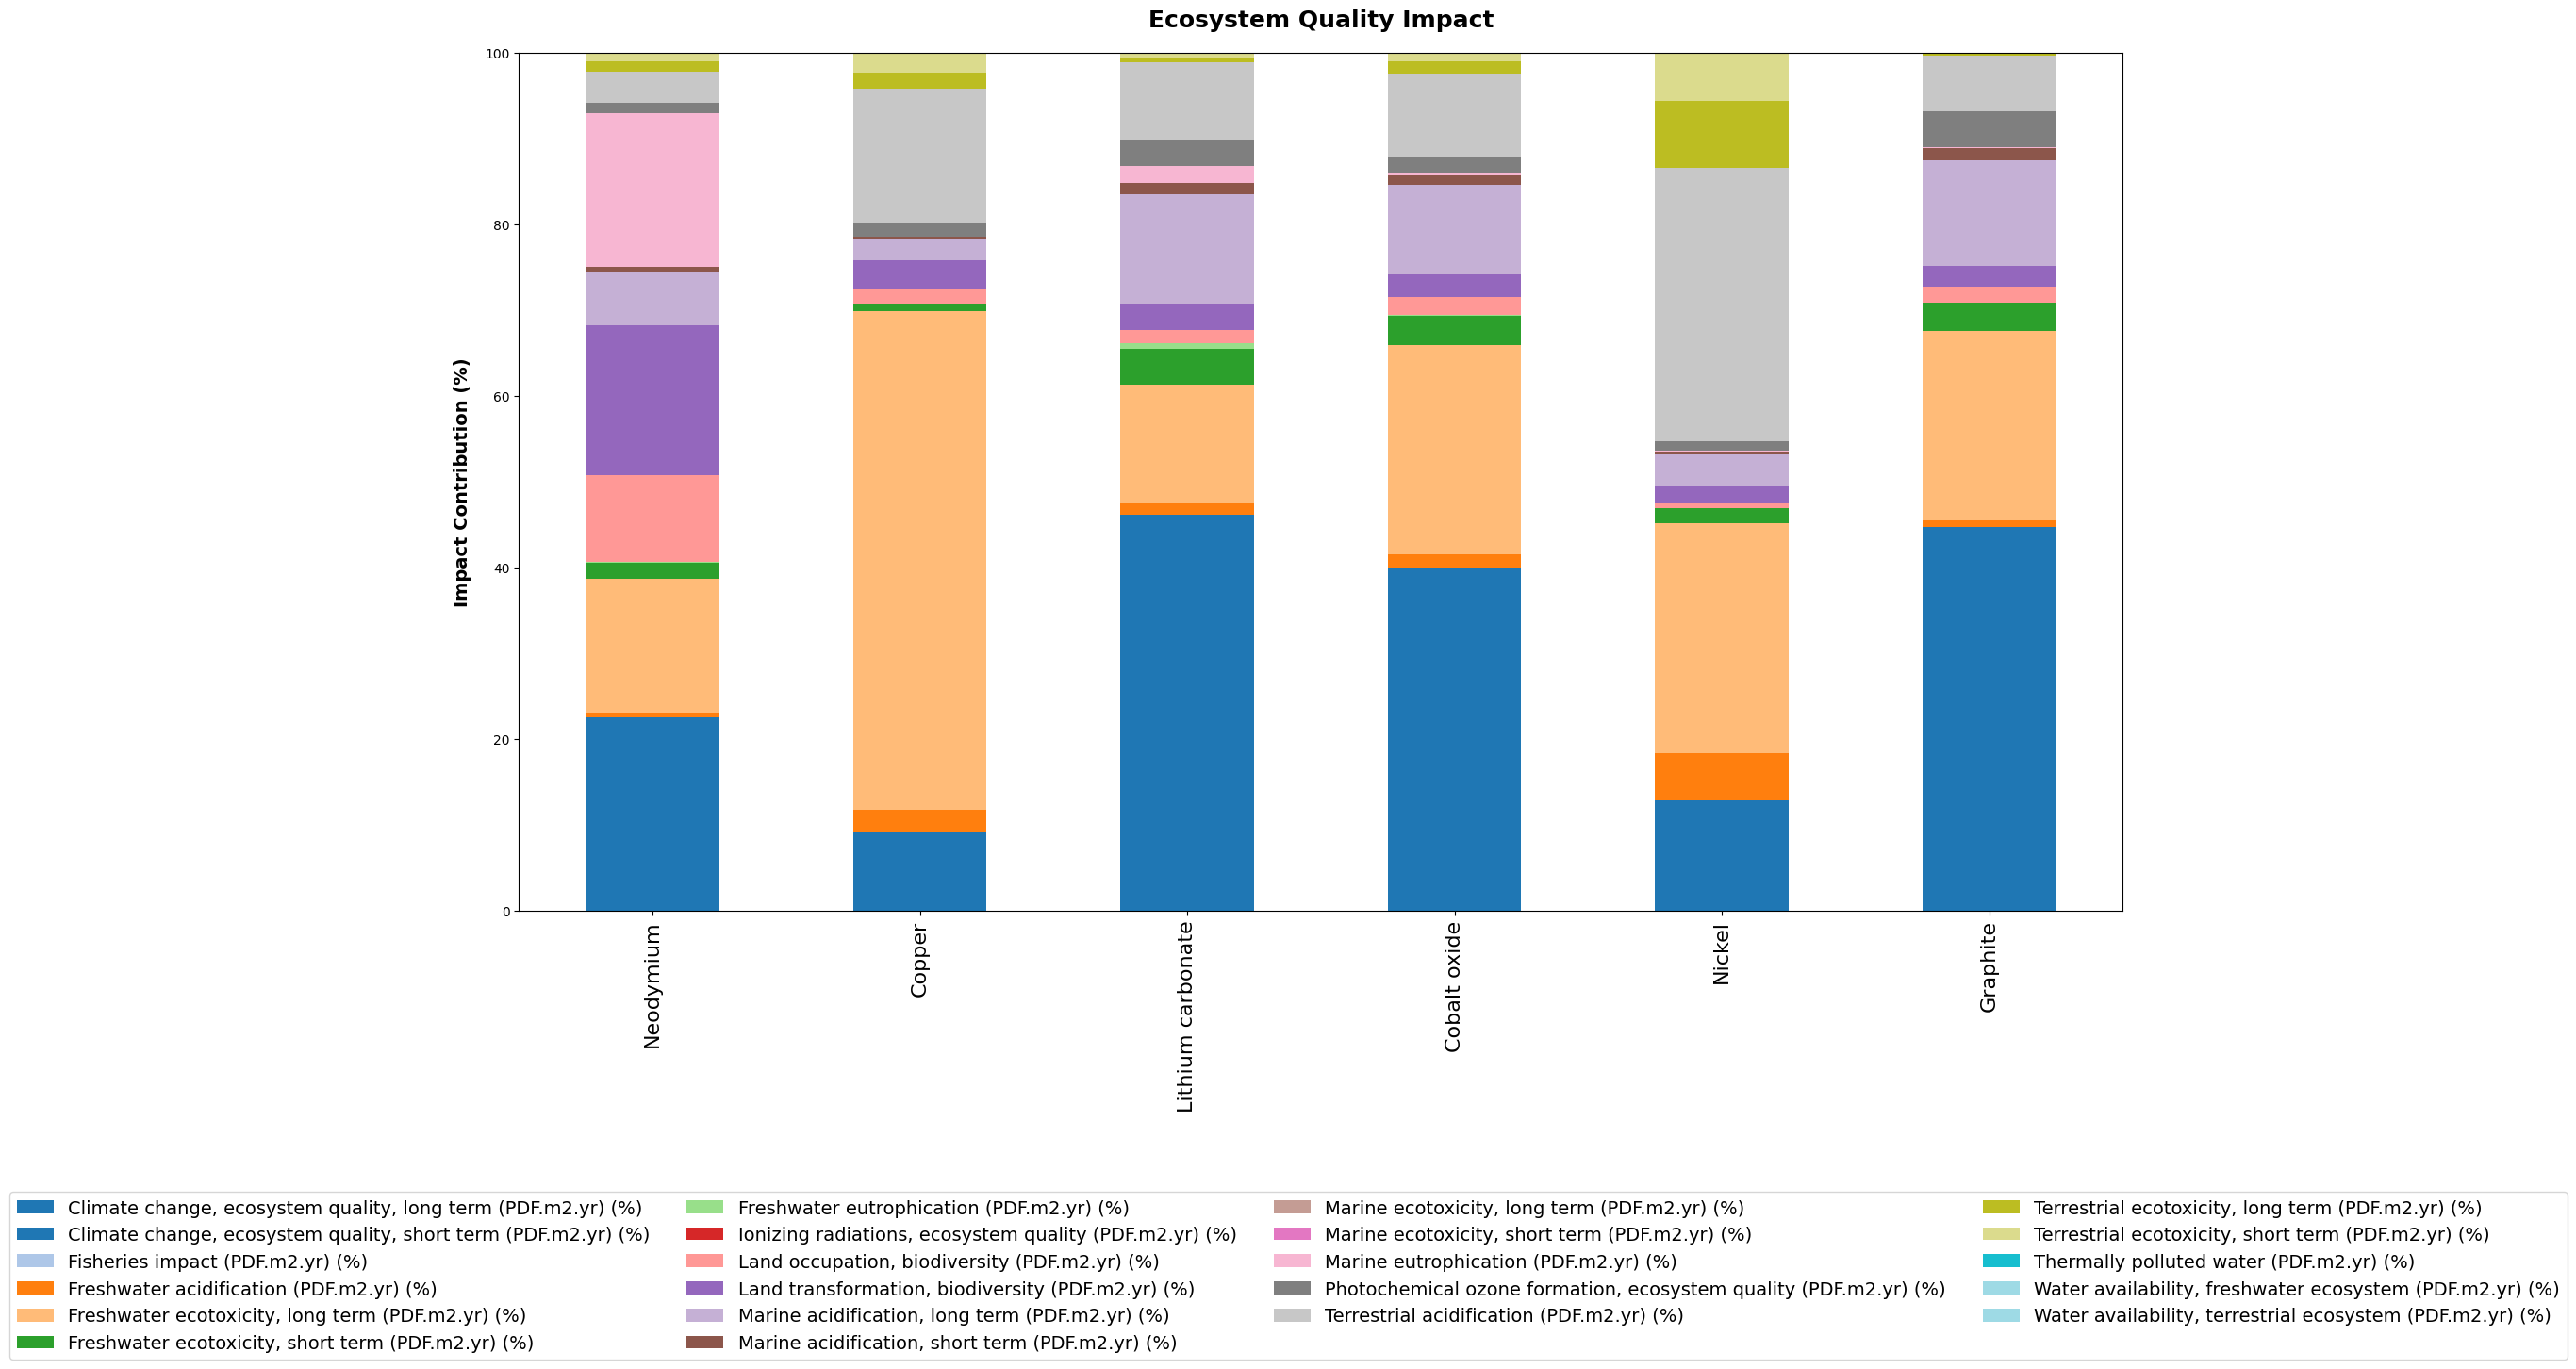

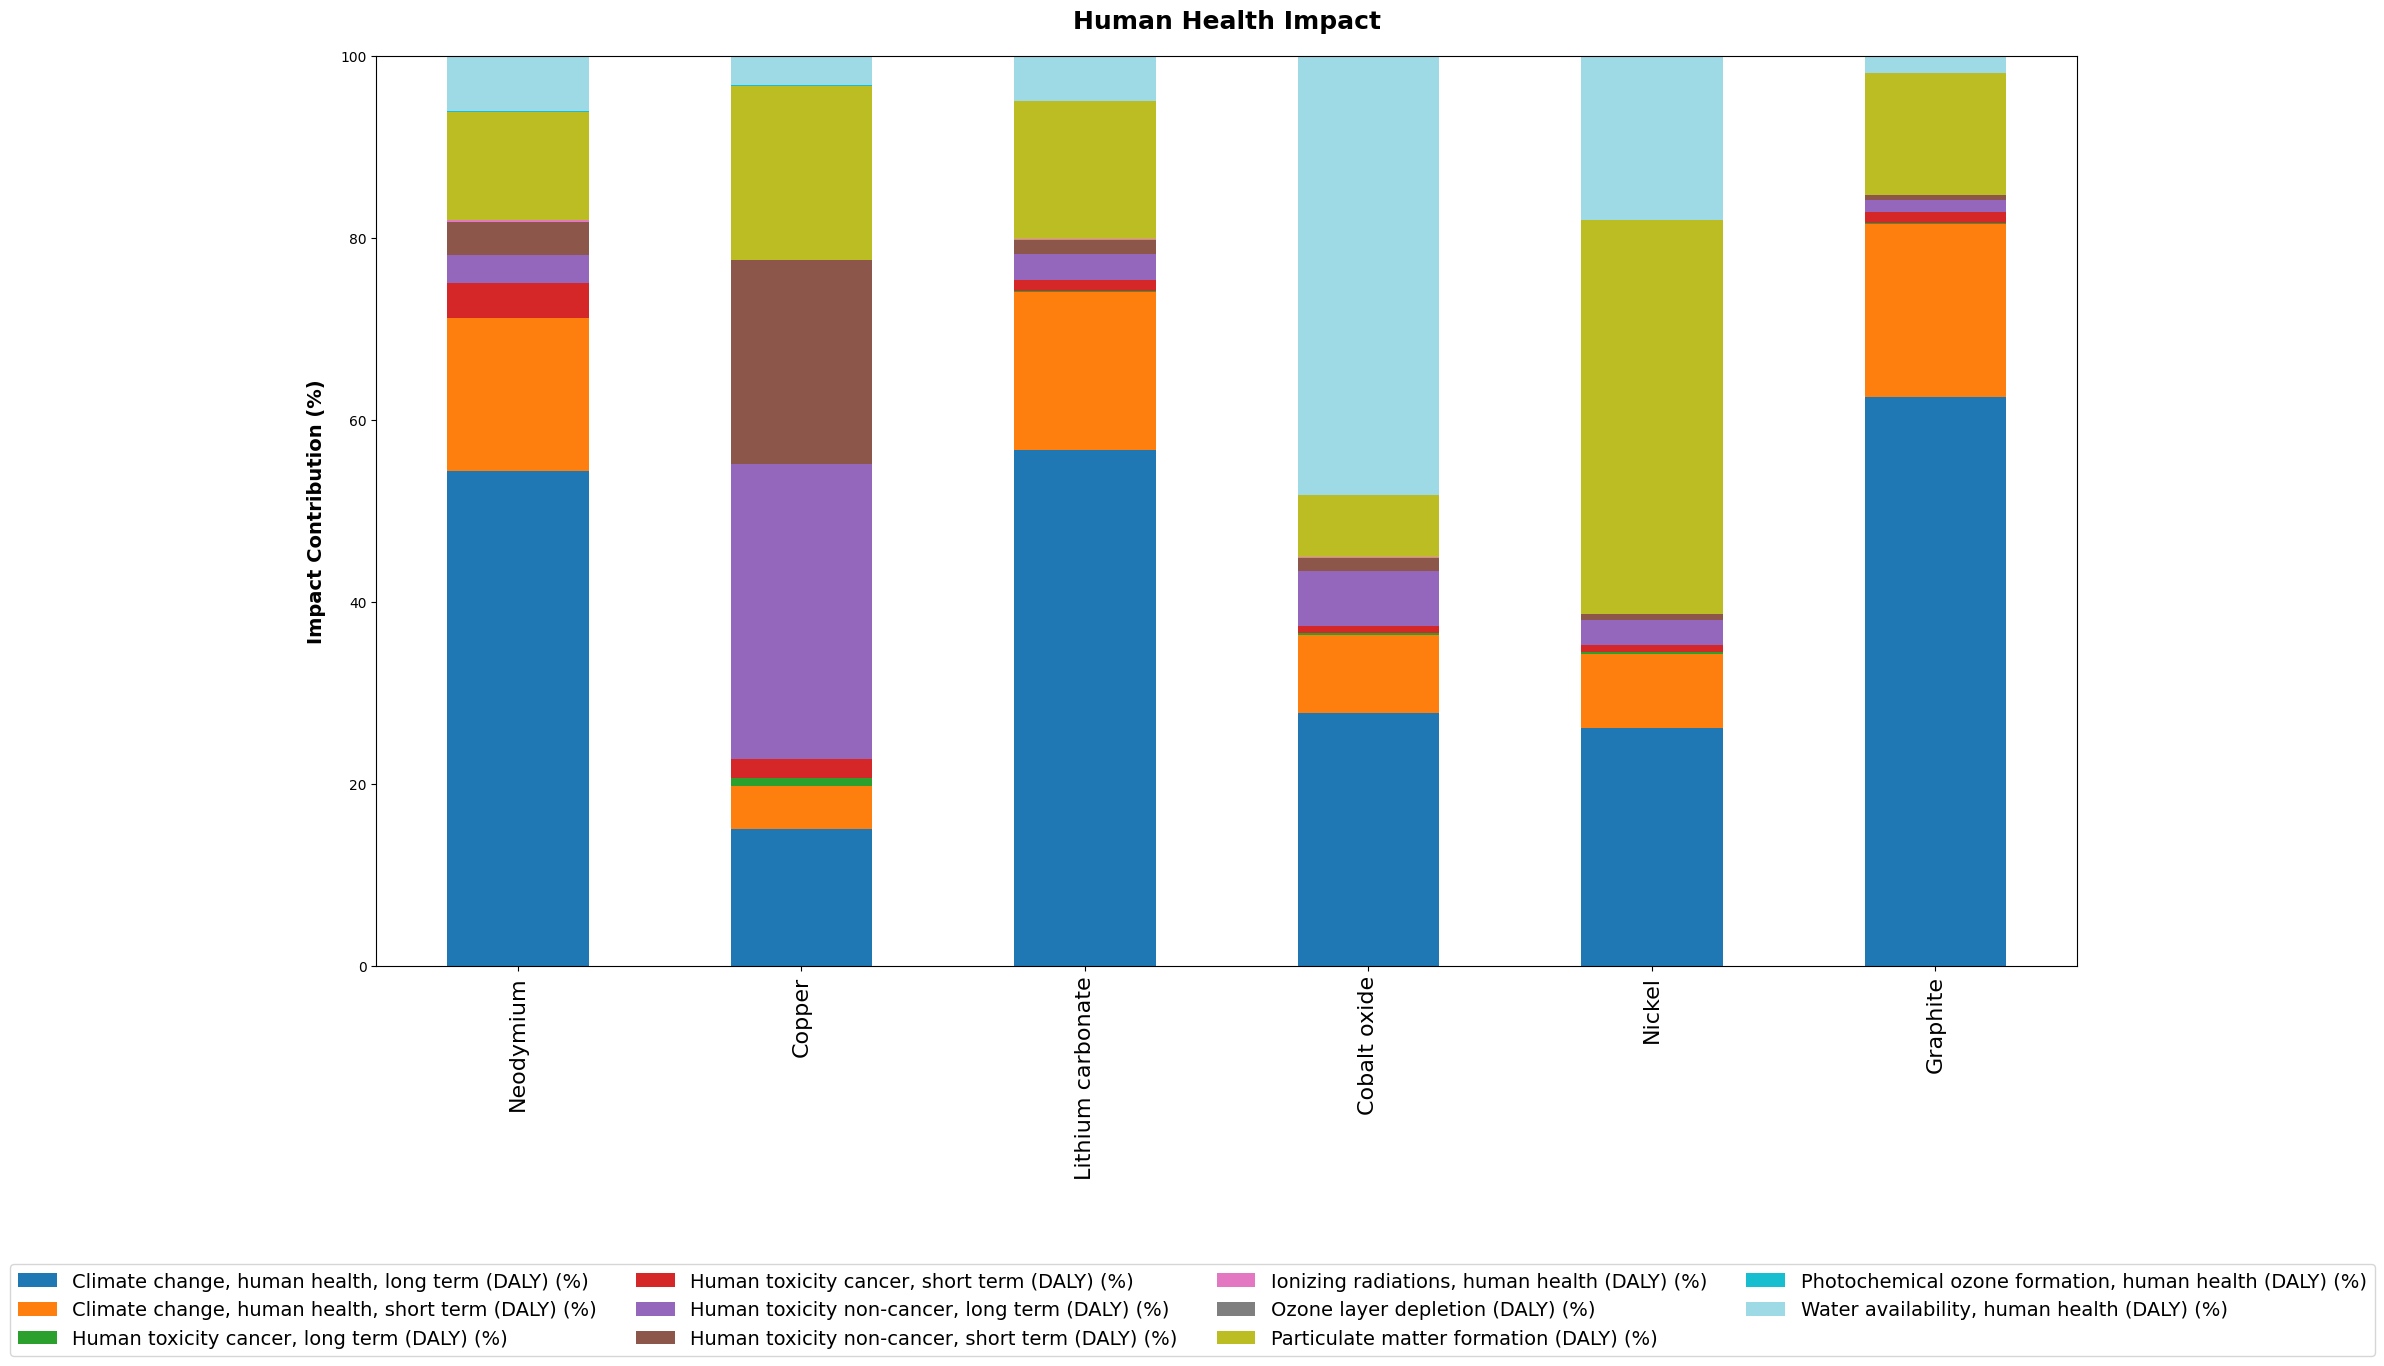

In [54]:
plot_iwplus_contributions(specific_lca_damage, save_path_eco="results/specific_lca_results/ecosystem_quality_contributions.png", save_path_hh="results/specific_lca_results/human_health_contributions.png")

# Calculate production-related impacts (e.g. scaled with scenarios)

## Import scenarios

They are from the Canadian Climate Institute and can be found [here](https://440megatonnes.ca/insight/canada-critical-minerals-clean-energy-transition/)

In [56]:
production_existing = pd.read_excel(r'data/Scenarios/scenarios_canadian_climate_institute.xlsx', sheet_name='Production_existing')
production_potential = pd.read_excel(r'data/Scenarios/scenarios_canadian_climate_institute.xlsx', sheet_name='Production_potential')
production_existing = production_existing[production_existing['Scenario']=='Domestic demand scenario']
production_potential = production_potential[production_potential['Scenario']=='Domestic demand scenario']

In [57]:
production_existing.rename(columns={'Mineral': 'Commodity'}, inplace=True)
production_potential.rename(columns={'Mineral': 'Commodity'}, inplace=True)

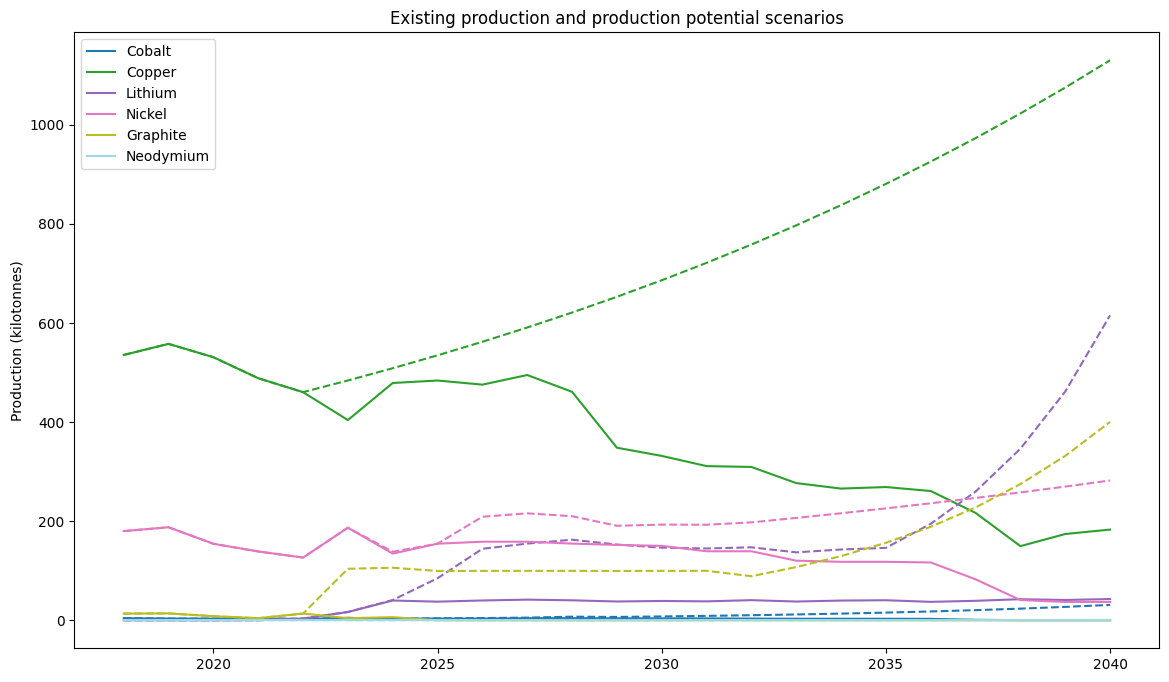

In [58]:
plot_scenario_production_comparison(production_existing, production_potential, save_path='results/demand_lca_results/cci_production_scenarios.png')

## Choose which LCI to associate with each mineral 

In [59]:
# Define a manual mapping to link the mineral in the scenario with the LCI of our choice
mineral_to_material_ei = {
    "Cobalt": "Cobalt oxide",
    "Copper": "Copper",
    "Lithium": "Lithium carbonate", 
    "Nickel": "Nickel",
    "Graphite": "Graphite",
    "Neodymium": "Neodymium"  
}


In [60]:
# Define a manual mapping to link the mineral in the scenario with the LCI of our choice
mineral_to_material_ri = {
    "Cobalt": "Cobalt oxide",
    "Copper": "Copper",
    "Lithium": "Lithium carbonate", 
    "Nickel": "Nickel",
    "Graphite": "Graphite",
    "Neodymium": "Neodymium"  
}

## Calculate the production-related impacts of scenarios

In [61]:
# With EI
projected_impacts_existing_production_ei = calculate_projected_impacts(production_existing, specific_lca_ei, mineral_to_material_ei)
projected_impacts_potential_production_ei = calculate_projected_impacts(production_potential, specific_lca_ei, mineral_to_material_ei)


In [62]:
# With Regioinvent
projected_impacts_existing_production_ri = calculate_projected_impacts(production_existing, specific_lca_ri,
                                                                       mineral_to_material_ri)
projected_impacts_potential_production_ri = calculate_projected_impacts(production_potential, specific_lca_ri,
                                                                        mineral_to_material_ri)


In [63]:
projected_impacts_existing_production_ri

,Year,Commodity,Total HH (DALY),Total EQ (PDF.m2.yr)
0,2018,Cobalt,1056.730970,1.301110e+08
1,2019,Cobalt,877.096159,1.079933e+08
2,2020,Cobalt,826.847465,1.018064e+08
3,2021,Cobalt,973.072655,1.198105e+08
4,2022,Cobalt,647.958428,7.978052e+07
...,...,...,...,...
133,2036,Neodymium,0.000000,0.000000e+00
134,2037,Neodymium,0.000000,0.000000e+00
135,2038,Neodymium,0.000000,0.000000e+00
136,2039,Neodymium,0.000000,0.000000e+00


In [68]:
impact_categories = [
#'Climate change ST (kg CO2 eq)',
'Total HH (DALY)',
'Total EQ (PDF.m2.yr)'    
]

In [69]:
import matplotlib.pyplot as plt

In [70]:
# Plot impacts per production scenario
plot_production_impacts(projected_impacts_existing_production_ei, production_existing, 
                             impact_categories, 
                             scenario_name='existing_production',
                            lci_used='EI')
plot_production_impacts(projected_impacts_potential_production_ei, production_potential, 
                             impact_categories, scenario_name='potential_production',
                        lci_used='EI')


Combined plot saved to results/demand_lca_results\combined_impact_existing_production_EI.png
Combined plot saved to results/demand_lca_results\combined_impact_potential_production_EI.png


In [71]:
# Plot impacts per production scenario
plot_production_impacts(projected_impacts_existing_production_ri, production_existing, 
                             impact_categories, 
                             scenario_name='existing_production',
                             lci_used='Regioinvent')
plot_production_impacts(projected_impacts_potential_production_ri, production_potential, 
                             impact_categories, 
                        scenario_name='potential_production',
                        lci_used='Regioinvent')

Combined plot saved to results/demand_lca_results\combined_impact_existing_production_Regioinvent.png
Combined plot saved to results/demand_lca_results\combined_impact_potential_production_Regioinvent.png
